# Mental Health Mapping on Social Media
## Using social media posts & supervised machine learning to understand the most prominent mental health issues in Canada during the COVID-19 pandemic


**Project**

A variety of research groups have explored social media data as a source of insights on mental health issues during COVID-19. As the pandemic took hold in early 2020 and lockdowns limited the ability for people to connect, social media saw a surge in usage, resulting in a a 10.5% increase in active social media users from July 2019 - July 2021. Social media was largely seen as a coping mechanism for users, with polls showing that 83% of active social media users used the tools to “help them cope with COVID-19 related lockdowns”. As such, social media data represents as a rich source of information for evaluating the mental health and overall well-being of communities over the course of the pandemic. 

Applying classification models to social media posts allows us to understand which types of mental health issues are most prevalent in online conversations during the pandemic. Using labelled posts from disease-specific conversations on Reddit, we can build a model that allows us to predict the mental health condition being discussed in a social post. We can then apply this model to Tweets with location data, allowing us to understand which mental health issues are most prominent online across different regions during the pandemic.

**Approach**

Four mental health issues will be evaluated: Depression, Anxiety, Bipolar disorder and Schizophrenia.

Reddit posts from r/Anxiety, r/Bipolar, r/Schizophrenia will be used as labelled inputs. These posts will be used to train a text classification model to interpret the specific indication of mental health posts on Twitter. By analyzing the distribution of Tweets within each mental health indication, we aim to understand which mental health issues have seen been the most prevalent during COVID-19 in Canada.

**Data Sources**

Reddit Data: 
Approximate file size: 8414 KB (~18407 mentions)
No geolocation data

Twitter Data:
Approximate File Size: 5174 KB (~7588 mentions)
Post-level geolocation data


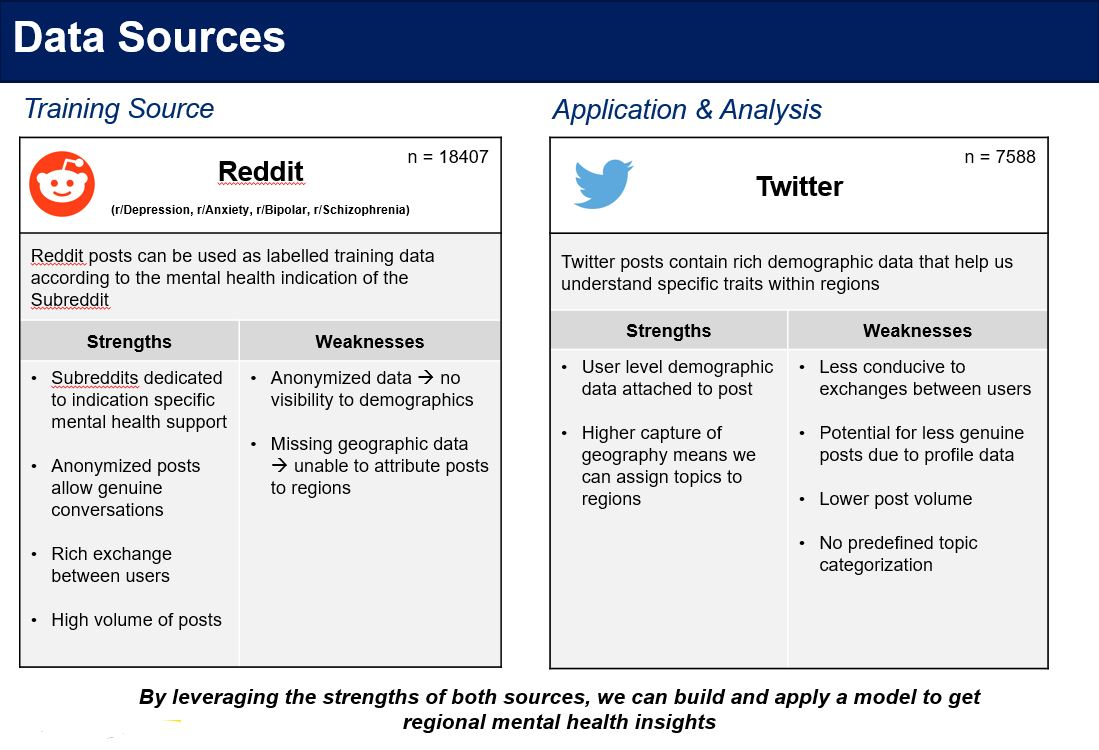

## Table of Contents

* [Reddit Exploratory Data Analysis](#1)
* [Text Preprocessing](#2)
* [Data Preparation & Encoding](#6)
* [Category Encoding](#7)
* [TF-IDF Vectorization](#4)
* [K-fold & Train-Test Split Prepration](#8)
* [Chi2 Correlation Analysis](#9)
* [Model Evaluation](#5)
    * [Naive Bayes](#10)
    * [Logistic Regression](#11)
    * [KNN](#12)
* [Model Comparison](#13)
* [Feature Importance](#14)
* [Model Application: Twitter Analysis](#15)
* [Limitations & Future Directions](#16)


   



### Import Libraries

In [3]:
#Data Analysis
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import scipy
import seaborn as sns
import pandas_profiling
from collections import Counter
import cv2
import datetime
format="%Y-%m-%d"

#Feature Engineering & Models
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

#NLP
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))
stopwords.update(['I', "I'm",'im', 'st', 'r', 'guys','hey','hello', 'hi'])

import re
from wordcloud import WordCloud, ImageColorGenerator
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nunnn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nunnn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nunnn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<a id="1"></a> <br>
## Reddit EDA

Reddit is used as a training source in order to build a supervised learning model that classifies posts into mental health indications.
Posts are sourced from subreddits dedicated to conversations around mental health issues  (r/depression, r/anxiety, r/bipolar, r/schizophrenia).

We can use this 'labelled' data to train a classification model, which will predict which of the four mental health topics listed above a post is discussing. First, we load the corpus of labelled Reddit posts:

In [4]:
#Load corpus of Reddit posts. 
#Dates: Jan 1 2020 - Sept 30 2021
os.chdir('C:\\Users\\nunnn\\Downloads')
reddit_df = pd.read_csv('reddit_corpus.csv')
reddit_df = pd.DataFrame(reddit_df)
reddit_df = reddit_df[reddit_df['Subreddit'].notna()]


#Convert Date values to datetime64 

reddit_df['Date'] = pd.to_datetime(reddit_df['Date'], format = "%m/%d/%Y")

#Analyze only posts from Jan 2020 - Sept 2021 (drop Oct 2021 posts)
reddit_df = reddit_df[(reddit_df['Date'] < '10/1/2021')]


#Reddit posts are extracted with the post Title and the "Snippet", which may be a further explanation of the post or a response by another user to the post. To avoid artifically inflating terms, we limit each 
# post to appearing only once in the dataset by removing duplicate "Title" & "Snippet" values.

reddit_df = reddit_df.drop_duplicates(subset=['Title'])
reddit_df = reddit_df.drop_duplicates(subset=['Snippet'])

#In order to capture the maximum amount of contextual conversation possible, we concatenate both columns to produce one column with all words in both the post title and reply/snippet.
content = []
for i in reddit_df.index:
    content.append(str(reddit_df['Title'][i]) + " " + str(reddit_df['Snippet'][i]))

reddit_df['content'] = content

reddit_df = reddit_df.drop_duplicates(subset=['content'])

reddit_df.head()

,Query Id,Query Name,Subreddit,Date,Title,Snippet,content
0,2.000748e+09,Mental Health,r/Anxiety,2020-05-08,Always need a deep breathe!,...Later on I heard another woman describing a...,Always need a deep breathe! ...Later on I hear...
1,2.000748e+09,Mental Health,r/Anxiety,2020-04-21,Let's post good news on the coronavirus here.,Agreed! I do like a nice latte once in a while...,Let's post good news on the coronavirus here. ...
2,2.000748e+09,Mental Health,r/Anxiety,2020-08-20,Does anyone else experience back to work anxiety,Only when I hated my job (when I was in retail...,Does anyone else experience back to work anxie...
3,2.000748e+09,Mental Health,r/Anxiety,2020-05-26,I cant walk through a town or even a village o...,Does your mom keep you updated on the news on ...,I cant walk through a town or even a village o...
4,2.000748e+09,Mental Health,r/Anxiety,2021-08-23,Just took my medication for the first time,I remember the lead up to beginning meds (I’m ...,Just took my medication for the first time I r...


In [5]:
#Total subreddit post volumes
Counter(reddit_df['Subreddit'])

Counter({'r/Anxiety': 4324,
         'r/bipolar': 3357,
         'r/Depression': 4370,
         'r/schizophrenia': 2877})

**Distribution of posts by Mental Health category**

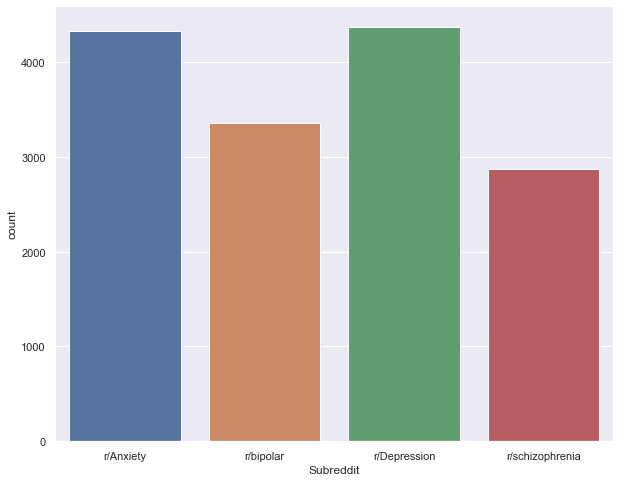

In [6]:
%matplotlib inline
sns.set(style='darkgrid')
plt.figure(figsize=(10,8))
ax = sns.countplot(x='Subreddit', data=reddit_df)
plt.savefig('counts.png')

**Distribution of post lengths within each mental health category**

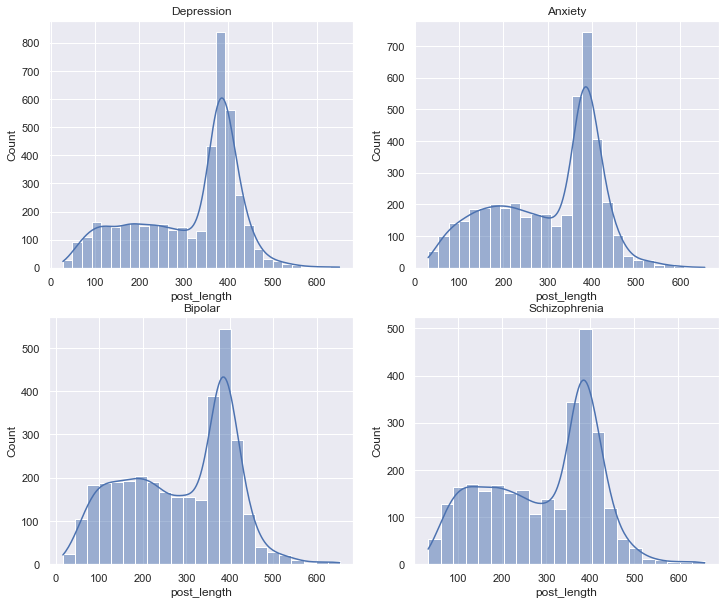

In [7]:
reddit_df['post_length'] = reddit_df['content'].str.len()


fig = plt.figure(figsize=(12,10))

rows=2
columns = 2

fig.add_subplot(rows, columns, 1)
sns.histplot(reddit_df['post_length'][reddit_df['Subreddit'] == 'r/Depression'], kde=True)
#plt.axis('off')
plt.title('Depression')

fig.add_subplot(rows, columns, 2)
sns.histplot(reddit_df['post_length'][reddit_df['Subreddit'] == 'r/Anxiety'], kde=True)
#plt.axis('off')
plt.title('Anxiety')

fig.add_subplot(rows, columns, 3)
sns.histplot(reddit_df['post_length'][reddit_df['Subreddit'] == 'r/bipolar'], kde=True)
#plt.axis('off')
plt.title('Bipolar')

fig.add_subplot(rows, columns, 4)
sns.histplot(reddit_df['post_length'][reddit_df['Subreddit'] == 'r/schizophrenia'], kde=True)
#plt.axis('off')
plt.title('Schizophrenia')



plt.savefig('post_length.png')
reddit_df['post_length'].describe()

plt.show()

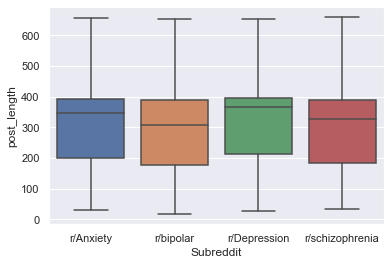

In [8]:
sns.boxplot(data=reddit_df, x='Subreddit', y='post_length')
plt.savefig('post_length_boxplot.png')
plt.show()

In [9]:
#profile = pandas_profiling.ProfileReport(reddit_df)
#profile.to_file(output_file = 'reddit_df.html')

<a id="2"></a> <br>
## Text Preprocessing

The first step in creating a text classification model is to run the necessary preprocessing on all posts

In [10]:
#Data Cleaning - Content Field
#Reddit posts are storied as a list of string values. To process each string value in the list, iterate the function over each string item in the list. Then return formatted lists
# to string format

print(reddit_df['content'][95])

lowercase_posts = []
for i in reddit_df.index:
    lowercase_posts.append(reddit_df['content'][i].lower())

reddit_df['content'] = lowercase_posts

print('          ')
print(reddit_df['content'][95])

#Remove punctuation from posts
strip_punctuation = []
for i in reddit_df.index:
    strip_punctuation.append(reddit_df['content'][i].translate(str.maketrans('','',string.punctuation)))

reddit_df['content'] = strip_punctuation
print('          ')
print(reddit_df['content'][95])

#Tokenize each string input to generate list of lists containing string values
tokenized_posts = []
for i in reddit_df.index:
    tokenized_posts.append(word_tokenize(reddit_df['content'][i]))

reddit_df['content'] = tokenized_posts
print('          ')
print(reddit_df['content'][95])

#Remove stopwords

filtered_posts = []
for i in reddit_df.index:
    filtered_posts.append([w for w in reddit_df['content'][i] if w not in stopwords])
    
reddit_df['content'] = filtered_posts
print('          ')
print(reddit_df['content'][95])

#Convert processed text from list to string

new_strings = []
for i in reddit_df.index:
    new_strings.append(' '.join(reddit_df['content'][i]))

reddit_df['content'] = new_strings
print('          ')
print(reddit_df['content'][95])

wn = WordNetLemmatizer()
lemmatized_posts = []

for i in reddit_df.index:
    lemmatized_content = []
    post = reddit_df['content'][i]
    post_words = post.split(" ")
    for word in post_words:
        lemmatized_content.append(wn.lemmatize(word, pos='v'))
    lemmatized_post = " ".join(lemmatized_content)
    lemmatized_posts.append(lemmatized_post)

reddit_df['content'] = lemmatized_posts
print('          ')
print(reddit_df['content'][95])

#reddit_df

contracting COVID-19, has trigged my past anxiety, depression, panic attacks ... idk whats wrong with me & i have no-one irl to discuss with How are you feeling with covid? I think joining a chat room and such might help! Maybe a couple of discords!
          
contracting covid-19, has trigged my past anxiety, depression, panic attacks ... idk whats wrong with me & i have no-one irl to discuss with how are you feeling with covid? i think joining a chat room and such might help! maybe a couple of discords!
          
contracting covid19 has trigged my past anxiety depression panic attacks  idk whats wrong with me  i have noone irl to discuss with how are you feeling with covid i think joining a chat room and such might help maybe a couple of discords
          
['contracting', 'covid19', 'has', 'trigged', 'my', 'past', 'anxiety', 'depression', 'panic', 'attacks', 'idk', 'whats', 'wrong', 'with', 'me', 'i', 'have', 'noone', 'irl', 'to', 'discuss', 'with', 'how', 'are', 'you', 'feeling', 

<a id="7"></a> <br>
## Category Encoding

Numeric values are assigned to mental health categories by creating a dictionary of key value pairs in order to format the data for input into predictive models.

In [11]:
topic_codes = {'r/Depression' : 0,
                      'r/Anxiety' : 1,
                      'r/bipolar' : 2,
                      'r/schizophrenia' : 3}

reddit_df['topic_code'] = reddit_df['Subreddit']
reddit_df = reddit_df.replace({'topic_code':topic_codes})

reddit_df[['content','Subreddit','topic_code']].sample(frac=1).head()

,content,Subreddit,topic_code
3064,anyone experience upper back neck pain ’ anxio...,r/Anxiety,1
11673,let die mustnt take medicine depression ed ok ...,r/Depression,0
9450,help parent bipolar child diagnose bipolar 2 a...,r/bipolar,2
607,anxiety sundays one feel way zoom 30000 feet w...,r/Anxiety,1
1042,smoke weed anxiety depression think help find ...,r/Anxiety,1


<a id="4"></a> <br>
## TF-IDF 

TF-IDF Vectors will be used as features to train our predictive model. TF-IDF scores represent the relative importance of terms in both documents and the entire corpus. In this case, each reddit post within a subreddit represents a "document" and the entire set of posts represents our corpus.

In order to convert text into a machine-learning readable format, the text must have a numeric representation. TF-IDF achieves this by assigning a score to each term in our posts that capture the relative importance of the term in the document. 

***Definitions:***

**Term Frequency (TF):**

A normalized measure of how frequently a term appears in a document. In this measure, it is assummed that words which appear more frequently are of greater importance

tf(w) = count(w)/total words in document

**Inverse Document Frequency (IDF):**

IDF helps to reduce the importance of terms that have a high term frequency, but are very common across all documents and are therefore have less impact on the meaning of a post.A measure of how "important" a term is by assessing how common it is across all documents.

idf(w) = log(total number of documents/number of documents containing w)


**TF-IDF:** 

The product of term frequency and inverse document frequency. This gives us a normalized score for how important a word is within a document.

tf-idf(w) = tf(w) * idf(w)



**Here, the parameters are set for TF-IDF vectorization.**

Parameters:

ngram_range: The upper and lower boundary of the range of n-values for different n-grams to be extracted. n-grams are continuous sequences of characters that appear sequentally. 
Setting ngram_range to (1,1) instructs the algorithm to extract only single words (unigrams). This can also be set to both unigrams and bigrams (1,2), or only bigrams (2,2).

min_df = This instructs the algorithm to ignore terms which have a document frequency lower than the given threshold. Document Frequency is the number of documents (posts) containing
a particular term.

max_df = This instructs the algorithm to ignore terms which have a document frequency higher than the given threshold.

max_features = The maximum amount of features to accept per document. We will set this to 500 (well above average post length) to capture all features.

stop_words = Words to exclude from feature list. We will use the stopwords variable which has already been prepared.

Each document is now transformed into a TF-IDF vector. Each vector represents a document, with the numbers corresponding to the TF-IDF score for each word in the document. Fitting is performed only on the training data, as testing data should be used only to evaluate the model (model should not be fit to testing data).

In [12]:
ngram_range = (1,2)
min_df = 0
max_df = 1.0
max_features = 500  #We'll use 500 features as it is well above the average post length
stop_words = stopwords

<a id="8"></a> <br>
## KFold & Train-Test Split Preparation

In [13]:
#Here data is prepared for use with cross_val_scores, using KFold cross validation
tfidf = TfidfVectorizer(encoding = 'utf-8', 
                       ngram_range = ngram_range,
                       min_df = min_df,
                       max_df = max_df,
                       lowercase=False, 
                       max_features = max_features,
                       stop_words = None, 
                       norm = 'l2', 
                       sublinear_tf = True)

x = tfidf.fit_transform(reddit_df['content']).toarray()
y = reddit_df['topic_code']
print(x.shape)

(14928, 500)


In [14]:
#Here, data is split into training and testing data for quick sample testing & confusion matrix

x_train, x_test, y_train, y_test = train_test_split(reddit_df['content'], reddit_df['topic_code'], test_size = 0.20, random_state=9)

tfidf = TfidfVectorizer(encoding = 'utf-8', 
                       ngram_range = ngram_range,
                       min_df = min_df,
                       max_df = max_df,
                       lowercase=False, 
                       max_features = max_features,
                       stop_words = None, 
                       norm = 'l2', 
                       sublinear_tf = True)

features_train = tfidf.fit_transform(x_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(x_test).toarray()
labels_test = y_test
print(features_test.shape)


(11942, 500)
(2986, 500)


In [15]:
#Check which words occur most frequently in the training dataset:
wordcounts = Counter(' '.join(x_train).split()).most_common()
wordcounts[:25]

[('’', 10432),
 ('anxiety', 5752),
 ('get', 4739),
 ('feel', 4617),
 ('like', 4198),
 ('depression', 3458),
 ('go', 3030),
 ('think', 2773),
 ('help', 2567),
 ('know', 2490),
 ('make', 2360),
 ('people', 2321),
 ('time', 2199),
 ('bipolar', 2180),
 ('schizophrenia', 2009),
 ('take', 1996),
 ('really', 1973),
 ('dont', 1848),
 ('want', 1808),
 ('depress', 1726),
 ('try', 1702),
 ('work', 1662),
 ('life', 1653),
 ('one', 1441),
 ('even', 1422)]

In [16]:
#View words used as features in TFIDF
features_example = tfidf.get_feature_names()
features_example[:25]

['10',
 'able',
 'absolutely',
 'accept',
 'act',
 'actually',
 'adhd',
 'advice',
 'affect',
 'afraid',
 'age',
 'ago',
 'almost',
 'alone',
 'already',
 'also',
 'always',
 'another',
 'answer',
 'antidepressants',
 'anxiety',
 'anxiety attack',
 'anxiety depression',
 'anxiety get',
 'anxious']

In [17]:
x_train[0]

'always need deep breathe later hear another woman describe similar feel friend say felt like belt tighten around chest give anxiety would recommend take test see coronavirus ’ least could eliminate cause concern ’ know'

In [18]:
features_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.16620744, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.27385066, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [19]:
#Run this cell to see the items and indices in our TF-IDF vector
#dict(sorted(tfidf.vocabulary_.items(), key=lambda item: item[1]))

<a id="9"></a> <br>
## Chi2 Correlation Analysis

Before running our model, we can build a sense of which terms are likely to be predictive of class using a Chi2 test. This function will compute the chi-squared test statistics between each feature (term) and class (mental health indication). Because chi2 tests measure the dependence between variables, we are able to see which features which are most likely to be highly dependent on class, and therefore more relevant for classification. Using this information, we can return the unigrams and bigrams that are most closely associated with each mental health topic. In this case we see that there is quite a lot of crossover among the most highly correlated unigrams in each category, which may impact model performance.

In [20]:
for Subreddit, topic_code in sorted(topic_codes.items()):
    features_chi2 = chi2(features_train, labels_train == topic_code)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [w for w in feature_names if len(w.split(' '))==1]
    bigrams = [w for w in feature_names if len(w.split(' '))==2]
    print("# '{}':".format(Subreddit))
    print("  . Top correlated unigrams:\n    . {}".format('\n    . '.join(unigrams[-10:])))
    print("  . Top correlated bigrams:\n    . {}".format('\n    . '.join(bigrams[-3:])))

# 'r/Anxiety':
  . Top correlated unigrams:
    . chest
    . heart
    . depress
    . depression
    . anxious
    . panic
    . schizophrenia
    . bipolar
    . attack
    . anxiety
  . Top correlated bigrams:
    . anxiety get
    . anxiety attack
    . panic attack
# 'r/Depression':
  . Top correlated unigrams:
    . happy
    . symptoms
    . life
    . suicide
    . suicidal
    . anxiety
    . bipolar
    . schizophrenia
    . depress
    . depression
  . Top correlated bigrams:
    . anyone else
    . bipolar disorder
    . suicidal thoughts
# 'r/bipolar':
  . Top correlated unigrams:
    . depressive
    . mood
    . disorder
    . episodes
    . anxiety
    . schizophrenia
    . episode
    . mania
    . manic
    . bipolar
  . Top correlated bigrams:
    . depressive episode
    . diagnose bipolar
    . bipolar disorder
# 'r/schizophrenia':
  . Top correlated unigrams:
    . symptoms
    . paranoid
    . anxiety
    . voice
    . delusions
    . psychotic
    . hallucinati

<a id="5"></a> <br>
## Model Evaluation 

We will test 3 classification models to see which model is able to most effectively predict the mental health indication a social media post is discussing:

* Multinomial Naive Bayes
* Multiclass Logistic Regression
* K-Nearest Neighbours


<a id="10"></a> <br>
### Naive Bayes

In [21]:
#Get current parameters
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
print(mnb.get_params())

#For Naive Bayes, the parameters will be left unchanged

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


In [22]:
#Using KFold cross validation. Splitting into train and test data is taken care of for each iteration, so declaring x_train, x_test etc. is not necessary. Based on low variation 
#in fold scores for each metric, mean is selected to determine the value for each metric to assign to the model.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

model_evaluation_kfold_mnb = {}
accuracy_scores = cross_val_score(mnb, x, y, cv=cv, scoring = 'accuracy')
print('Accuracy Fold Scores')
print(accuracy_scores)
model_evaluation_kfold_mnb.update({'Accuracy': accuracy_scores.mean()})

print('Precision Fold Scores')
precision_scores = cross_val_score(mnb, x, y, cv=cv, scoring = 'precision_weighted') 
print(precision_scores)
model_evaluation_kfold_mnb.update({'Precision': precision_scores.mean()})

print('Recall Fold Scores')
recall_scores = cross_val_score(mnb, x, y, cv=cv, scoring = 'recall_weighted') 
print(recall_scores)
model_evaluation_kfold_mnb.update({'Recall': recall_scores.mean()})

print('F1 Fold Scores')
f1_scores = cross_val_score(mnb, x, y, cv=cv, scoring = 'f1_weighted')
print(f1_scores)
model_evaluation_kfold_mnb.update({'F1': f1_scores.mean()})

model_evaluation_kfold_mnb

Accuracy Fold Scores
[0.77260549 0.77863362 0.780643   0.77126591 0.7716008  0.7722706
 0.77896852 0.77863362 0.77561956 0.78365707]
Precision Fold Scores
[0.78566063 0.79158948 0.79230973 0.78368362 0.78502412 0.7876912
 0.79034561 0.79258603 0.78539904 0.79532985]
Recall Fold Scores
[0.77260549 0.77863362 0.780643   0.77126591 0.7716008  0.7722706
 0.77896852 0.77863362 0.77561956 0.78365707]
F1 Fold Scores
[0.77264128 0.77967205 0.78113039 0.77161718 0.77199705 0.77325862
 0.77929999 0.77975374 0.77571033 0.78404349]


{'Accuracy': 0.7763898191560616,
 'Precision': 0.7889619323029871,
 'Recall': 0.7763898191560616,
 'F1': 0.7769124130460903}

Multiple Naive Bayes Classification Report
              precision    recall  f1-score   support

           0       0.72      0.84      0.77       928
           1       0.77      0.84      0.80       815
           2       0.81      0.68      0.74       661
           3       0.89      0.71      0.79       582

    accuracy                           0.78      2986
   macro avg       0.80      0.77      0.78      2986
weighted avg       0.79      0.78      0.78      2986



{'Naive Bayes': [0.7940880924468263, 0.7782987273945077]}

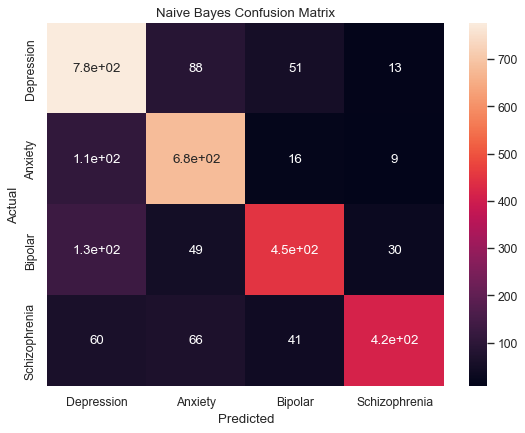

In [23]:
#To generate Confusion Matrix, use train test split as a sample and perform 
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

#Fit model to training data
mnb_model = mnb.fit(features_train, labels_train)

#Predict outputs from the model using our test data
mnb_predictions = mnb_model.predict(features_test)

#Print model evaluation report
print ("Multiple Naive Bayes Classification Report")
print(classification_report(labels_test, mnb_predictions))

#Confusion Matrix

figure(figsize=(8, 6), dpi=80)
cfmatrix = confusion_matrix(labels_test, mnb_predictions)
sns.heatmap(cfmatrix, annot=True, xticklabels=['Depression','Anxiety','Bipolar','Schizophrenia'], yticklabels=['Depression','Anxiety','Bipolar','Schizophrenia'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Naive Bayes Confusion Matrix')

#Create dictionary to store values for model comparison. Include model accuracy on both Training and Testing data to ensure model isn't overfit

model_evaluation = {'Naive Bayes' : [accuracy_score(labels_train, mnb.predict(features_train)),accuracy_score(labels_test, mnb_predictions)]}

model_evaluation

<a id="11"></a> <br>
### Logistic Regression

In [24]:
#Get current parameters
from sklearn.linear_model import LogisticRegression
lgreg = LogisticRegression()
print(lgreg.get_params())
#In order to use logistic regression for multiclass (non-binary) classification, we have to set the multi_class parameter. We will choose OVR (One vs Rest) Classification

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [25]:
#One vs Rest and Multinomial classification will be tested
lgreg = LogisticRegression(multi_class='ovr', max_iter = 300) #One vs rest classification
lgregm = LogisticRegression(multi_class='multinomial', max_iter = 300) #Multinomial classification

In [26]:
#Using KFold cross validation for One vs rest classification
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

model_evaluation_kfold_lgreg = {}
accuracy_scores = cross_val_score(lgreg, x, y, cv=cv, scoring = 'accuracy')
print('Accuracy Fold Scores')
print(accuracy_scores)
model_evaluation_kfold_lgreg.update({'Accuracy': accuracy_scores.mean()})

print('Precision Fold Scores')
precision_scores = cross_val_score(lgreg, x, y, cv=cv, scoring = 'precision_weighted') 
print(precision_scores)
model_evaluation_kfold_lgreg.update({'Precision': precision_scores.mean()})

print('Recall Fold Scores')
recall_scores = cross_val_score(lgreg, x, y, cv=cv, scoring = 'recall_weighted') 
print(recall_scores)
model_evaluation_kfold_lgreg.update({'Recall': recall_scores.mean()})

print('F1 Fold Scores')
f1_scores = cross_val_score(lgreg, x, y, cv=cv, scoring = 'f1_weighted')
print(f1_scores)
model_evaluation_kfold_lgreg.update({'F1': f1_scores.mean()})

model_evaluation_kfold_lgreg

Accuracy Fold Scores
[0.84058942 0.84326859 0.8513061  0.84326859 0.84293369 0.84092431
 0.83824514 0.8509712  0.84092431 0.84293369]
Precision Fold Scores
[0.84710218 0.84995356 0.85679501 0.84988267 0.84913583 0.84844303
 0.8444127  0.85600558 0.84617332 0.8502127 ]
Recall Fold Scores
[0.84058942 0.84326859 0.8513061  0.84326859 0.84293369 0.84092431
 0.83824514 0.8509712  0.84092431 0.84293369]
F1 Fold Scores
[0.83965746 0.84253774 0.85027072 0.84265228 0.84167408 0.84026433
 0.83757573 0.85008389 0.8399026  0.84201928]


{'Accuracy': 0.8435365036838579,
 'Precision': 0.8498116584597906,
 'Recall': 0.8435365036838579,
 'F1': 0.8426638099221012}

In [27]:
#Test with Multinomial Classification
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

model_evaluation_kfold_lgregm = {}
accuracy_scores = cross_val_score(lgregm, x, y, cv=cv, scoring = 'accuracy')
print('Accuracy Fold Scores')
print(accuracy_scores)
model_evaluation_kfold_lgregm.update({'Accuracy': accuracy_scores.mean()})

print('Precision Fold Scores')
precision_scores = cross_val_score(lgregm, x, y, cv=cv, scoring = 'precision_weighted') 
print(precision_scores)
model_evaluation_kfold_lgregm.update({'Precision': precision_scores.mean()})

print('Recall Fold Scores')
recall_scores = cross_val_score(lgregm, x, y, cv=cv, scoring = 'recall_weighted') 
print(recall_scores)
model_evaluation_kfold_lgregm.update({'Recall': recall_scores.mean()})

print('F1 Fold Scores')
f1_scores = cross_val_score(lgregm, x, y, cv=cv, scoring = 'f1_weighted')
print(f1_scores)
model_evaluation_kfold_lgregm.update({'F1': f1_scores.mean()})

model_evaluation_kfold_lgregm

Accuracy Fold Scores
[0.83991962 0.84527796 0.85231078 0.84125921 0.84092431 0.84159411
 0.83824514 0.84862693 0.8422639  0.84326859]
Precision Fold Scores
[0.84521246 0.85056443 0.85603708 0.84565966 0.84610433 0.84758104
 0.84241807 0.85209683 0.84612711 0.84909612]
Recall Fold Scores
[0.83991962 0.84527796 0.85231078 0.84125921 0.84092431 0.84159411
 0.83824514 0.84862693 0.8422639  0.84326859]
F1 Fold Scores
[0.83916716 0.84473083 0.85143034 0.84059339 0.83995118 0.84108232
 0.83765553 0.8479178  0.84149087 0.84238151]


{'Accuracy': 0.8433690555927662,
 'Precision': 0.8480897120986766,
 'Recall': 0.8433690555927662,
 'F1': 0.8426400926658735}

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       928
           1       0.83      0.93      0.88       815
           2       0.86      0.76      0.80       661
           3       0.94      0.78      0.85       582

    accuracy                           0.85      2986
   macro avg       0.86      0.84      0.85      2986
weighted avg       0.86      0.85      0.85      2986



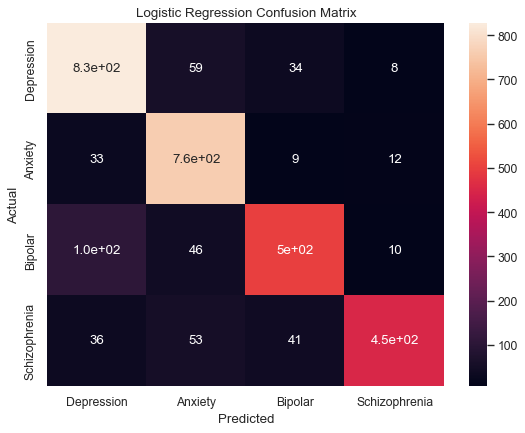

In [28]:
#One vs Rest classification is selected due to slightly higher evaluation metrics and lower runtime. Again the model is run on a sample 80:20 train test split
#to produce a confusion matrix.
lgreg = LogisticRegression(multi_class='ovr', max_iter = 300)
lgreg_model = lgreg.fit(features_train, labels_train)
lgreg_predictions = lgreg_model.predict(features_test)

#Print model evaluation report
print ("Logistic Regression Classification Report")
print(classification_report(labels_test, lgreg_predictions))

#Confusion Matrix
figure(figsize=(8, 6), dpi=80)
cfmatrix = confusion_matrix(labels_test, lgreg_predictions)
sns.heatmap(cfmatrix, annot=True, xticklabels=['Depression','Anxiety','Bipolar','Schizophrenia'], yticklabels=['Depression','Anxiety','Bipolar','Schizophrenia'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Logistic Regression Confusion Matrix')

#Add values for model comparison
model_evaluation.update({'Logistic Regression' : [accuracy_score(labels_train, lgreg.predict(features_train)),accuracy_score(labels_test, lgreg_predictions)]})

<a id="12"></a> <br>
### KNN

In [29]:
#Get current parameters
knn = KNeighborsClassifier(n_neighbors = 27)
print(knn.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 27, 'p': 2, 'weights': 'uniform'}


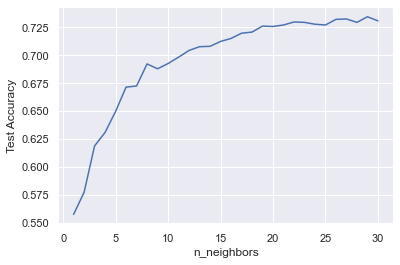

In [30]:
#Tuning the parameters - find best value for n_neighbors
accuracy_scores = []

k_range = range(1,31)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(features_train, labels_train)
    knn_predictions = knn.predict(features_test)
    accuracy_scores.append(metrics.accuracy_score(labels_test, knn_predictions))
    

plt.plot(k_range, accuracy_scores)
plt.xlabel('n_neighbors')
plt.ylabel('Test Accuracy')
plt.show()

#We see that the highest accuracy is at a value of 27 neighbors

In [31]:
#Using KFold cross validation with KNN. Based on the analysis above, we will use n_neighbors = 27
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

model_evaluation_kfold_knn = {}
accuracy_scores = cross_val_score(knn, x, y, cv=cv, scoring = 'accuracy')
print('Accuracy Fold Scores')
print(accuracy_scores)
model_evaluation_kfold_knn.update({'Accuracy': accuracy_scores.mean()})

print('Precision Fold Scores')
precision_scores = cross_val_score(knn, x, y, cv=cv, scoring = 'precision_weighted') 
print(precision_scores)
model_evaluation_kfold_knn.update({'Precision': precision_scores.mean()})

print('Recall Fold Scores')
recall_scores = cross_val_score(knn, x, y, cv=cv, scoring = 'recall_weighted') 
print(recall_scores)
model_evaluation_kfold_knn.update({'Recall': recall_scores.mean()})

print('F1 Fold Scores')
f1_scores = cross_val_score(knn, x, y, cv=cv, scoring = 'f1_weighted')
print(f1_scores)
model_evaluation_kfold_knn.update({'F1': f1_scores.mean()})

model_evaluation_kfold_knn

Accuracy Fold Scores
[0.72505023 0.72505023 0.72371065 0.73208305 0.72002679 0.7364367
 0.73576691 0.73744139 0.7364367  0.73107837]
Precision Fold Scores
[0.74472113 0.73994693 0.73442088 0.7469127  0.73357448 0.7574812
 0.75035315 0.7513602  0.74850536 0.75022438]
Recall Fold Scores
[0.72505023 0.72505023 0.72371065 0.73208305 0.72002679 0.7364367
 0.73576691 0.73744139 0.7364367  0.73107837]
F1 Fold Scores
[0.72339227 0.7236289  0.72194812 0.73102162 0.71866634 0.73502423
 0.73418882 0.73673095 0.73542632 0.73049313]


{'Accuracy': 0.730308104487609,
 'Precision': 0.7457500424207757,
 'Recall': 0.730308104487609,
 'F1': 0.7290520709930262}

KNN Classification Report
              precision    recall  f1-score   support

           0       0.69      0.79      0.74       928
           1       0.70      0.84      0.76       815
           2       0.78      0.60      0.68       661
           3       0.84      0.64      0.73       582

    accuracy                           0.73      2986
   macro avg       0.75      0.72      0.73      2986
weighted avg       0.74      0.73      0.73      2986



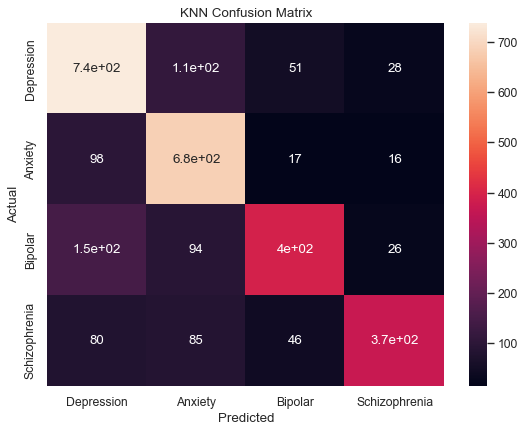

In [32]:
#Run example with one trian test split for confusion matrix

knn = KNeighborsClassifier(n_neighbors = 27)
knn_model = knn.fit(features_train, labels_train)

knn_predictions = knn_model.predict(features_test)

#Print model evaluation report
print ("KNN Classification Report")
print(classification_report(labels_test, knn_predictions))

#Confusion Matrix
figure(figsize=(8, 6), dpi=80)
cfmatrix = confusion_matrix(labels_test, knn_predictions)
sns.heatmap(cfmatrix, annot=True, xticklabels=['Depression','Anxiety','Bipolar','Schizophrenia'], yticklabels=['Depression','Anxiety','Bipolar','Schizophrenia'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('KNN Confusion Matrix')

#Add values for model comparison
model_evaluation.update({'KNN' : [accuracy_score(labels_train, knn.predict(features_train)),accuracy_score(labels_test, knn_predictions)]})

<a id="13"></a> <br>
## Model Comparison

By comparing performance metrics across all models, we can assess which model performs the best for our purpose. To do this, we'll compare metrics from our K-Fold cross validation for each model. We'll also view the accuracy of the model on both training and test data to ensure the model is not overfit.

In [33]:
#View model performance on both training and test data from 1-fold sample run to test for overfitting
model_fit = pd.DataFrame.from_dict(model_evaluation.items())
model_fit = model_fit.rename(columns={0:'Model', 1:'Testing_Accuracy'})
model_fit[['Training Accuracy','Testing Accuracy']] = pd.DataFrame(model_fit.Testing_Accuracy.tolist(), index = model_fit.index)

model_fit = model_fit[['Model','Training Accuracy','Testing Accuracy']]

model_fit

,Model,Training Accuracy,Testing Accuracy
0,Naive Bayes,0.794088,0.778299
1,Logistic Regression,0.859236,0.850636
2,KNN,0.762686,0.732418


In [34]:
#Compare performance metrics from K-fold cross validation across all models
mnb_kfold = pd.DataFrame.from_dict(model_evaluation_kfold_mnb.items()).transpose()
lgreg_kfold = pd.DataFrame.from_dict(model_evaluation_kfold_lgreg.items()).transpose()
knn_kfold = pd.DataFrame.from_dict(model_evaluation_kfold_knn.items()).transpose()

model_eval = mnb_kfold.iloc[[1]].append(lgreg_kfold.iloc[[1]]).append(knn_kfold.iloc[[1]])

model_eval.index = ['Naive Bayes','Logistic Regression','KNN']
model_eval.columns = ['Accuracy','Precision','Recall','F1 Score']

model_eval

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.77639,0.788962,0.77639,0.776912
Logistic Regression,0.843537,0.849812,0.843537,0.842664
KNN,0.730308,0.74575,0.730308,0.729052


It appears that none of the models are overfit to the training data, as model performance is similar on both training and testing data. From the data, we can see that the Logistic Regression model performed the best across all metrics. We will therefore select Logistic Regression as the model for our use case.

<a id="14"></a> <br>
## Determining the Most Important Features for Classification in our Selected Model

Now that we've determined Logistic Regression to be the highest performing model, we can view the features that are most important for discrimination between classes in our model. This helps us understand which keywords cause a post to be classified into one category vs another.

In [35]:
#Store dictionary of tf_idf features and their corresponding index in the array. This method returns a dictionary with each feature and it's index in the transformed training set
tfidf_values = tfidf.vocabulary_

#define function to retrieve a feature based on it's given index
def get_feature_from_index(v):
    for k, value in tfidf_values.items():
        if value == v:
            return k

#store coefficient values for each feature from logistic regression model for given topic
depression_feature_importance = lgreg_model.coef_[0]  # 0 corresponds to Depression topic classification

#Iterate over each feature and retrieve both the feature name and its corresponding coefficient to determine importance of each feature in classification for a given topic
coefficients = {}
for i,v in enumerate(depression_feature_importance):
    scores = {get_feature_from_index(i): (depression_feature_importance[i])}
    coefficients.update(scores)
    
top_features_depression = sorted(coefficients.items(), key=lambda x: x[1], reverse=True)

print('Depression - Top Features')
print('               ')
print(*top_features_depression[0:25], sep='\n')
print('               ')
print('---------------')

#Repeat for each category

anxiety_feature_importance = lgreg_model.coef_[1]  # 1 corresponds to Anxiety topic classification

coefficients = {}
for i,v in enumerate(anxiety_feature_importance):
    scores = {get_feature_from_index(i): (anxiety_feature_importance[i])}
    coefficients.update(scores)
    
top_features_anxiety = sorted(coefficients.items(), key=lambda x: x[1], reverse=True)

print('Anxiety - Top Features')
print('               ')
print(*top_features_anxiety[0:25], sep='\n')
print('               ')
print('---------------')


bipolar_feature_importance = lgreg_model.coef_[2]  # 2 corresponds to Bipolar topic classification

coefficients = {}
for i,v in enumerate(bipolar_feature_importance):
    scores = {get_feature_from_index(i): (bipolar_feature_importance[i])}
    coefficients.update(scores)
    
top_features_bipolar = sorted(coefficients.items(), key=lambda x: x[1], reverse=True)

print('Bipolar - Top Features')
print('               ')
print(*top_features_bipolar[0:25], sep='\n')
print('               ')
print('---------------')


schizophrenia_feature_importance = lgreg_model.coef_[3]  # 3 corresponds to Schizophrenia topic classification

coefficients = {}
for i,v in enumerate(schizophrenia_feature_importance):
    scores = {get_feature_from_index(i): (schizophrenia_feature_importance[i])}
    coefficients.update(scores)
    
top_features_schizophrenia = sorted(coefficients.items(), key=lambda x: x[1], reverse=True)

print('Schizophrenia - Top Features')
print('               ')
print(*top_features_schizophrenia[0:25], sep='\n')
print('               ')
print('---------------')

Depression - Top Features
               
('depression', 9.849674975519255)
('depress', 6.592820350110787)
('depression anxiety', 3.3349218725530654)
('suicide', 2.629784089931508)
('antidepressants', 2.4954407364905005)
('social anxiety', 2.2349589428881496)
('life', 2.0871523353359516)
('suicidal', 1.8316067857280895)
('friends', 1.8308899866510906)
('kill', 1.8156437303012176)
('shit', 1.7760971737163278)
('school', 1.6975645354618472)
('game', 1.6792543810156557)
('cant', 1.5810459493196487)
('friend', 1.5601110468242005)
('happy', 1.5499179950058826)
('want', 1.48669700289986)
('everything', 1.4258234793193365)
('nothing', 1.4124419670325445)
('love', 1.411373598010799)
('parent', 1.401451319757116)
('get better', 1.3999734408668518)
('suffer', 1.3948441296749186)
('move', 1.3829251355352947)
('depressive', 1.3693398622106714)
               
---------------
Anxiety - Top Features
               
('anxiety', 18.534947201041653)
('anxious', 4.307925060135878)
('panic', 2.8200206174

<a id="15"></a> <br>
## Twitter Analysis

Using the classification model trained on Reddit forum conversations related to mental health, we can categorize Tweets into various mental health indications. The key value proposition of using Twitter data is that it also includes user information, including the location of the author. We can use this information to assess changes in mental health conversation volumes regionally, and in response to COVID-19 changes in various provinces.

Based on the model performance noted above, we will use the Logistic Regression model to classify tweets.

### Read & Format Data

In [37]:
#Load twitter corpus
twitter_df = pd.read_csv('twitter_corpus2.csv', encoding = 'unicode_escape')
twitter_df = pd.DataFrame(twitter_df)

twitter_df.head()

,Unnamed: 0,Query Id,Query Name,Date,Snippet,Country,Region,City Code,Location Name
0,0,2000747571,Mental Health,9/17/2021,"Also, some could say thatÃ¢ÂÂs schizophrenia...",Canada,Ontario,NaN,"ON, CAN"
1,1,2000747571,Mental Health,8/18/2021,Ã¢ÂÂA man Ã°ÂÂÂ¨ goes to doctor Ã°ÂÂÂ¨Ã¢...,Canada,Ontario,CAN.ON.Toronto,"Toronto, ON, CAN"
2,2,2000747571,Mental Health,8/10/2020,as in.. whenever someone with adhd and/or auti...,Canada,Alberta,NaN,"AB, CAN"
3,3,2000747571,Mental Health,5/14/2021,Anxiety is the worst Ã°ÂÂÂ£,Canada,Ontario,CAN.ON.Toronto,"Toronto, ON, CAN"
4,4,2000747571,Mental Health,1/14/2020,CAN XICHENG STANS STOP DEPRESSING ME WITH EVER...,Canada,Ontario,CAN.ON.Toronto,"Toronto, ON, CAN"


In [38]:

#Perform text preprocessing on tweets

#Drop N/A values, and include only posts which have an identified geographic region

twitter_df = twitter_df[twitter_df['Snippet'].notna()]
twitter_df = twitter_df[twitter_df['Region'].notna()]
twitter_df = twitter_df.drop_duplicates(subset=['Snippet'])

#Text processing
#Data Cleaning - Snippet

print(twitter_df['Snippet'][0])


#Remove author names from the posts, which are any terms starting with '@'
stripped_authors = []
for i in twitter_df.index:
    stripped_authors.append(' '.join(w for w in twitter_df['Snippet'][i].split(' ') if not w.startswith('@')))
    
twitter_df['Snippet'] = stripped_authors
print(twitter_df['Snippet'][0])

#Remove all non-alphanumeric characters to clean up text and remove symbols, emojis, etc.
stripped_strings = []
for i in twitter_df.index:
    stripped_strings.append(re.sub(r'[^A-Za-z0-9 ]+', '', twitter_df['Snippet'][i]))
        
twitter_df['Snippet'] = stripped_strings
print(twitter_df['Snippet'][0])

#Twitter posts are stored as a list of string values. To process each string value in the list, iterate the function over each string item in the list. Then return formatted lists
# to string format
lowercase_posts = []
for i in twitter_df.index:
    lowercase_posts.append(twitter_df['Snippet'][i].lower())

twitter_df['Snippet'] = lowercase_posts
print(twitter_df['Snippet'][0])

#Remove punctuation from posts
strip_punctuation = []
for i in twitter_df.index:
    strip_punctuation.append(twitter_df['Snippet'][i].translate(str.maketrans('','',string.punctuation)))

twitter_df['Snippet'] = strip_punctuation
print(twitter_df['Snippet'][0])

#Tokenize each string input to generate list of lists containing string values
tokenized_posts = []
for i in twitter_df.index:
    tokenized_posts.append(word_tokenize(twitter_df['Snippet'][i]))

twitter_df['Snippet'] = tokenized_posts
print(twitter_df['Snippet'][0])

#Remove stopwords

filtered_posts = []
for i in twitter_df.index:
    filtered_posts.append([w for w in twitter_df['Snippet'][i] if w not in stopwords])
    
twitter_df['Snippet'] = filtered_posts
print(twitter_df['Snippet'][0])

#Convert processed text from list to string

new_strings = []
for i in twitter_df.index:
    new_strings.append(' '.join(twitter_df['Snippet'][i]))

twitter_df['Snippet'] = new_strings
print(twitter_df['Snippet'][0])

#Lemmatize posts
wn = WordNetLemmatizer()
lemmatized_posts = []

for i in twitter_df.index:
    lemmatized_content = []
    post = twitter_df['Snippet'][i]
    post_words = post.split(" ")
    for word in post_words:
        lemmatized_content.append(wn.lemmatize(word, pos='v'))
    lemmatized_post = " ".join(lemmatized_content)
    lemmatized_posts.append(lemmatized_post)

twitter_df['Snippet'] = lemmatized_posts
print(twitter_df['Snippet'][0])

print('           ')

print('Formatted Dataframe:')

twitter_df.head()

Also, some could say thatÃ¢ÂÂs schizophrenia Ã°ÂÂÂ
Also, some could say thatÃ¢ÂÂs schizophrenia Ã°ÂÂÂ
Also some could say thats schizophrenia 
also some could say thats schizophrenia 
also some could say thats schizophrenia 
['also', 'some', 'could', 'say', 'thats', 'schizophrenia']
['also', 'could', 'say', 'thats', 'schizophrenia']
also could say thats schizophrenia
also could say thats schizophrenia
           
Formatted Dataframe:


,Unnamed: 0,Query Id,Query Name,Date,Snippet,Country,Region,City Code,Location Name
0,0,2000747571,Mental Health,9/17/2021,also could say thats schizophrenia,Canada,Ontario,NaN,"ON, CAN"
1,1,2000747571,Mental Health,8/18/2021,man go doctor say hes depress say life seem ha...,Canada,Ontario,CAN.ON.Toronto,"Toronto, ON, CAN"
2,2,2000747571,Mental Health,8/10/2020,whenever someone adhd andor autism something s...,Canada,Alberta,NaN,"AB, CAN"
3,3,2000747571,Mental Health,5/14/2021,anxiety worst,Canada,Ontario,CAN.ON.Toronto,"Toronto, ON, CAN"
4,4,2000747571,Mental Health,1/14/2020,xicheng stans stop depress every au ideablurb ...,Canada,Ontario,CAN.ON.Toronto,"Toronto, ON, CAN"


In [39]:
#Transform 
np.set_printoptions(threshold=1000)
tweets = twitter_df['Snippet']

#Convert Tweets to vectors
tweet_vectors = tfidf.transform(tweets).toarray()


#Run predictive model
tweet_predictions = lgreg_model.predict(tweet_vectors)
tweet_predictions = tweet_predictions.tolist()


#Generate dataframe showing tweet and its predicted mental health indication

tweet_classifications = {'Snippet': tweets, 'topic_code' : tweet_predictions}

tweet_df = pd.DataFrame(tweet_classifications)

categories = []
for i in tweet_df.index:
    if tweet_df['topic_code'][i] == 0:
        categories.append('Depression')
    elif tweet_df['topic_code'][i] == 1:
        categories.append('Anxiety')
    elif tweet_df['topic_code'][i] == 2:
        categories.append('Bipolar')
    elif tweet_df['topic_code'][i] == 3:
        categories.append('Schizophrenia')

tweet_df['Categories'] = categories

In [40]:
#Merge location data from twitter_df to add additional context for analysis
classified_tweets = pd.merge(tweet_df, twitter_df, on = 'Snippet', how ='inner')
classified_tweets = classified_tweets[['Date','Snippet','Categories','Country','Region']]
classified_tweets = classified_tweets.replace('QuÃ©bec', 'Quebec')  #Fix formatting
classified_tweets

,Date,Snippet,Categories,Country,Region
0,9/17/2021,also could say thats schizophrenia,Schizophrenia,Canada,Ontario
1,8/18/2021,man go doctor say hes depress say life seem ha...,Depression,Canada,Ontario
2,8/10/2020,whenever someone adhd andor autism something s...,Depression,Canada,Alberta
3,5/14/2021,anxiety worst,Anxiety,Canada,Ontario
4,1/14/2020,xicheng stans stop depress every au ideablurb ...,Depression,Canada,Ontario
...,...,...,...,...,...
7242,3/11/2020,twitter edit need ugh tire tell often like muc...,Depression,Canada,British Columbia
7243,2/10/2021,depression also allow,Depression,Canada,Ontario
7244,5/25/2021,depression acute try resign kpmgschief mental ...,Depression,Canada,Ontario
7245,10/1/2020,holy shit everyone today bff horrible days act...,Depression,Canada,Ontario


First, we can look at the distribution of posts among mental health categories to see which mental health indications have been most prevalent in social media discussions over the course of the pandemic. From the distributon we can see that posts which are indicative of Depression are the most prevalant in social media, followed by Anxiety, Schizophrenia and Bipolar disorder.

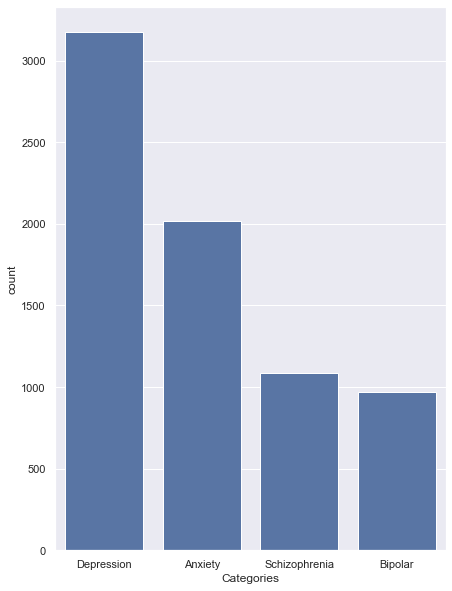

Schizophrenia  :  14.999%
Depression  :  43.784%
Anxiety  :  27.817999999999998%
Bipolar  :  13.399%


In [41]:
sns.set_color_codes('pastel')
sns.set(style='darkgrid')
sns.set(rc={'figure.figsize':(7,10)})
sns.countplot(x='Categories', data=classified_tweets, order = classified_tweets['Categories'].value_counts().index, color='b')
plt.show()

categories = []
percentages = []
for i in Counter(classified_tweets['Categories']):
    categories.append(i) 
    percentages.append(str(round(len(classified_tweets[classified_tweets['Categories']==i])/len(classified_tweets),5)*100) + '%')

zipped_values = zip(categories, percentages)
categories_dist = dict(zipped_values)

for k, v in categories_dist.items():
    print(k, ' : ', v)


Next, we look at the distribution of tweets by region to understand which areas are most highly represented in our dataset. In this case we can see Ontario makes up the vast majority (~61%) of posts

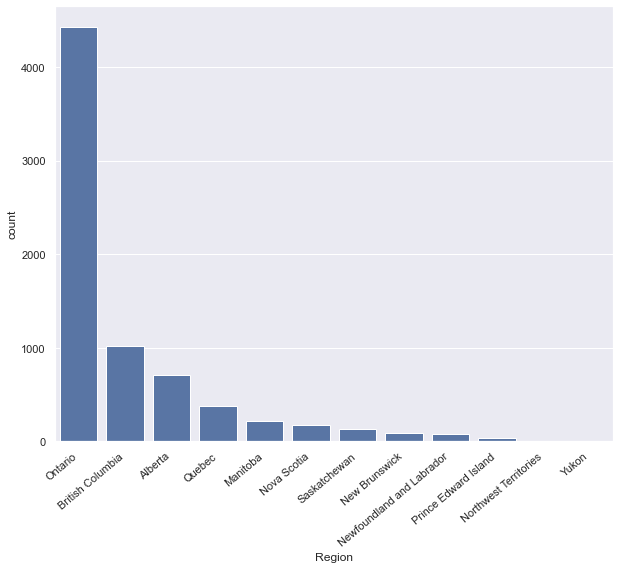

Ontario  :  61.101000000000006%
Alberta  :  9.825000000000001%
Saskatchewan  :  1.78%
British Columbia  :  13.991999999999999%
Quebec  :  5.216%
Newfoundland and Labrador  :  1.1039999999999999%
Northwest Territories  :  0.055%
Nova Scotia  :  2.387%
Manitoba  :  2.9530000000000003%
Prince Edward Island  :  0.428%
New Brunswick  :  1.1320000000000001%
Yukon  :  0.027999999999999997%


In [42]:
#View regional breakdown 
provinces = []
percentages = []
for i in Counter(classified_tweets['Region']):
    provinces.append(i) 
    percentages.append(str(round(len(classified_tweets[classified_tweets['Region']==i])/len(classified_tweets),5)*100) + '%')

zipped_values = zip(provinces, percentages)
regional_dist = dict(zipped_values)

#Plot counts
sns.set_color_codes('pastel')
sns.set(style='darkgrid')
plt.figure(figsize=(10,8))
ax = sns.countplot(x='Region', data=classified_tweets, order = classified_tweets['Region'].value_counts().index, color='b', label='# of Tweets')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.show()

#Show percentage breakdown
for k, v in regional_dist.items():
    print(k, ' : ', v)


To understand the mental health needs within various regions, we can breakdown social media posts within each region by their associated mental health indication as predicted by our logistic regression model. This gives us an idea of what the most pressing mental health issues are across Canada.

Below we can see that among the regions that are most highly represented in our data (Ontario, British Columbia, Alberta, Quebec), Depression and Anxiety come through as the two main areas of concern. Among provinces with less data, the distribution across indications becomes more even. In general, Depression and Anxiety remain the highest areas of concern for most smaller provinces. However, an interesting pattern emerges in Saskatchewan which is the only province where schizophrenia appears as a prominent mental health concern.

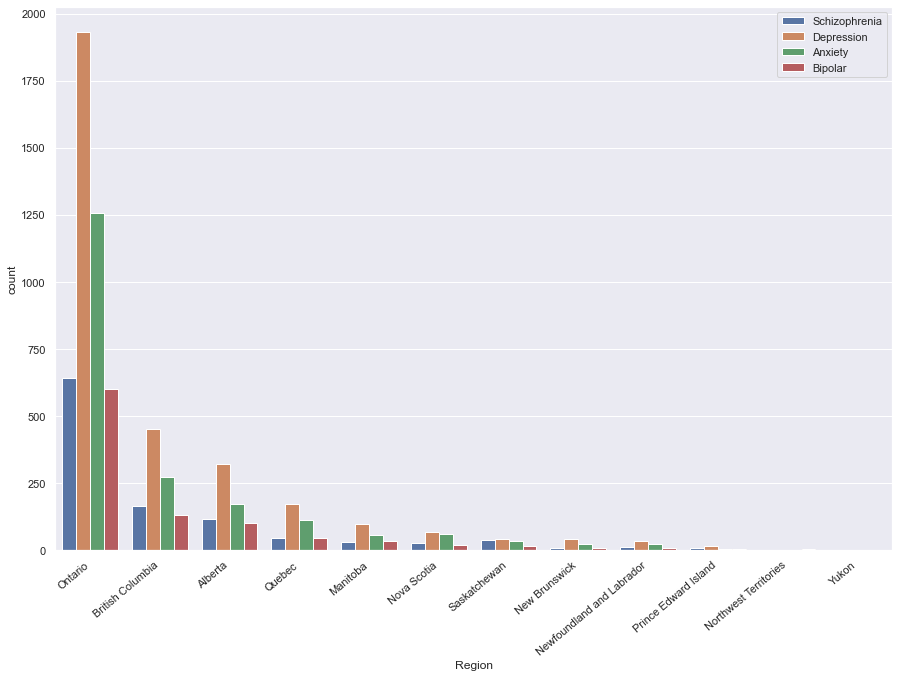

In [43]:
sns.set_color_codes('pastel')
sns.set(style='darkgrid')
plt.figure(figsize=(15,10))
ax = sns.countplot(x='Region', data=classified_tweets, order = classified_tweets['Region'].value_counts().index, hue='Categories')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.legend(loc='upper right')
plt.show()

In [44]:
#We can create a dataframe to view the underlying post numbers in our graph

depression = pd.DataFrame(classified_tweets[classified_tweets.Categories=='Depression'].groupby('Region')['Snippet'].count())
anxiety = pd.DataFrame(classified_tweets[classified_tweets.Categories=='Anxiety'].groupby('Region')['Snippet'].count())
bipolar = pd.DataFrame(classified_tweets[classified_tweets.Categories=='Bipolar'].groupby('Region')['Snippet'].count())
schizophrenia = pd.DataFrame(classified_tweets[classified_tweets.Categories=='Schizophrenia'].groupby('Region')['Snippet'].count())

regions_merged = pd.concat([depression,anxiety,bipolar,schizophrenia], join='outer', axis=1)

regions_merged.columns = ['Depression','Anxiety','Bipolar','Schizophrenia']

regions_merged

,Depression,Anxiety,Bipolar,Schizophrenia
Region,,,,
Alberta,322.0,173.0,100.0,117.0
British Columbia,450.0,271.0,130.0,163.0
Manitoba,96.0,56.0,33.0,29.0
New Brunswick,42.0,23.0,9.0,8.0
Newfoundland and Labrador,35.0,24.0,9.0,12.0
Nova Scotia,67.0,59.0,20.0,27.0
Ontario,1930.0,1255.0,602.0,641.0
Prince Edward Island,15.0,6.0,3.0,7.0
Quebec,173.0,113.0,46.0,46.0


<a id="16"></a> <br>
## Future Directions & Next Steps

**Limitations:**
* This project focused on building a classification model to predict the mental health indication of a social media post, and plotting the distribution of these mental health issues across regions in Canada during the pandemic. Further steps are needed to attribute changes in mental health discussions to COVID-19
* The model was trained on posts within 4 specific indications, and as a result may not generalize well to additional mental health topics
* The model showed some particular difficulty in correctly assigning the Bipolar class with a lower F1 score in this category compared to all others. In particular, the model had a tendency to improperly assign posts related to Depression into the Bipolar class
* The Tweets used in this analysis were curated via query to be related to mental health in some capacity (ie. contained some keyword related to mental health issues) – this model is may not perform well on generic tweets which are not related to mental health

**Future Directions & Next Steps:**
* Refine Twitter posts to ensure relation to COVID-19 - this will help analyst narrow in on the impact of COVID-19 related issues (ex: lockdowns, case surges) on mental health
* Time Series Analysis - map changes in topic volumes over time to view correlation with COVID-19 events such as lockdowns
